In [1]:
if __name__ == '__main__':
    import sys
    import os
    from pathlib import Path
    curr_file_path = Path(os.path.abspath(''))
    print(curr_file_path)
    sys.path.append(str(curr_file_path.parent))
    sys.path.append(os.path.join(str(curr_file_path.parent.parent.parent), 'fixed-point-finder'))

import numpy as np
import glob2 as glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
from sklearn.decomposition import PCA
from agents.networks.a2c_rnn import A2CRNN
from FixedPointFinderTorch import FixedPointFinderTorch as FixedPointFinder
from plot_utils import plot_fps
from copy import deepcopy as copy

DATA_BASE_DIR = '../../results/rl_agent_outputs'
PATCH_TYPES_PER_ENV = 3
OBS_SIZE = PATCH_TYPES_PER_ENV + 1
ACTION_SIZE = 2
HIDDEN_SIZE = 128


C:\Users\david.bell\work\favorably_connected\code\notebooks


In [2]:
load_path = 'structural_priors_in_rl_fixed_curr_optim_02_2024-12-04_22_56_50_041229_var_noise_0.0001_activity_weight_1.0/rnn_weights/09950.pth'
print(os.path.join(DATA_BASE_DIR, load_path).replace('\\','/'))

network = A2CRNN(
    input_size=OBS_SIZE + ACTION_SIZE + 1,
    action_size=ACTION_SIZE,
    hidden_size=HIDDEN_SIZE,
    device='cpu',
    var_noise=0,
)

with torch.no_grad():
    saved_checkpoint = torch.load(os.path.join(DATA_BASE_DIR, load_path).replace('\\','/'), weights_only=False)
    if 'network_state_dict' in saved_checkpoint:
        network.load_state_dict(saved_checkpoint['network_state_dict'])
    else:
        network.load_state_dict(saved_checkpoint)
    network.eval()

../../results/rl_agent_outputs/structural_priors_in_rl_fixed_curr_optim_02_2024-12-04_22_56_50_041229_var_noise_0.0001_activity_weight_1.0/rnn_weights/09950.pth


In [3]:
network.rnn.weight_hh.data

tensor([[ 0.0513, -0.7193,  0.5337,  ...,  0.0690, -0.0958,  1.0241],
        [ 0.0911, -1.1656,  0.2965,  ..., -0.3535, -0.2820,  0.0450],
        [ 0.0772,  0.0579,  0.0031,  ..., -0.4648, -0.4122, -0.2824],
        ...,
        [ 0.0324,  0.0981,  0.0189,  ..., -0.4223,  0.0861, -0.0933],
        [-0.1538,  0.0988, -0.0437,  ..., -0.0731, -0.4855, -0.0523],
        [-0.2347,  0.0710, -0.0582,  ...,  0.1038, -0.0115, -0.5210]])

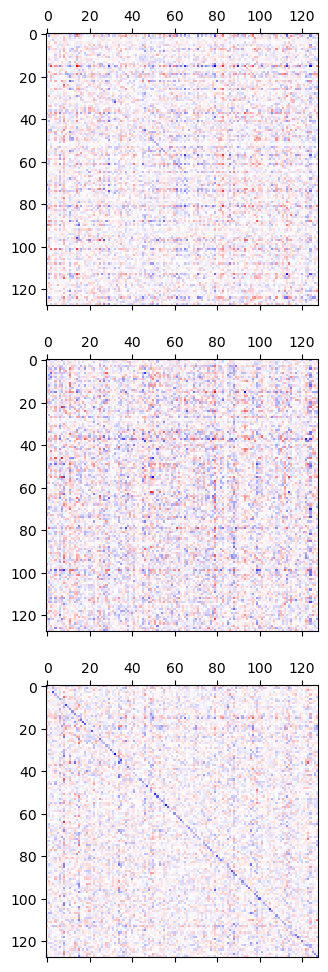

In [4]:
scale = 0.8
fig, axs = plt.subplots(3, 1, figsize=(6 * scale, 15 * scale))

w_hh = network.rnn.weight_hh.data.numpy()
m = np.abs(w_hh[:HIDDEN_SIZE, :]).max()
axs[0].matshow(network.rnn.weight_hh.data.numpy()[:HIDDEN_SIZE, :], cmap='bwr', vmin=-m, vmax=m)
m = np.abs(w_hh[HIDDEN_SIZE:2*HIDDEN_SIZE, :]).max()
axs[1].matshow(network.rnn.weight_hh.data.numpy()[HIDDEN_SIZE:2*HIDDEN_SIZE, :], cmap='bwr', vmin=-m, vmax=m)
m = np.abs(w_hh[2*HIDDEN_SIZE:3*HIDDEN_SIZE, :]).max()
axs[2].matshow(network.rnn.weight_hh.data.numpy()[2*HIDDEN_SIZE:3*HIDDEN_SIZE, :], cmap='bwr', vmin=-m, vmax=m)

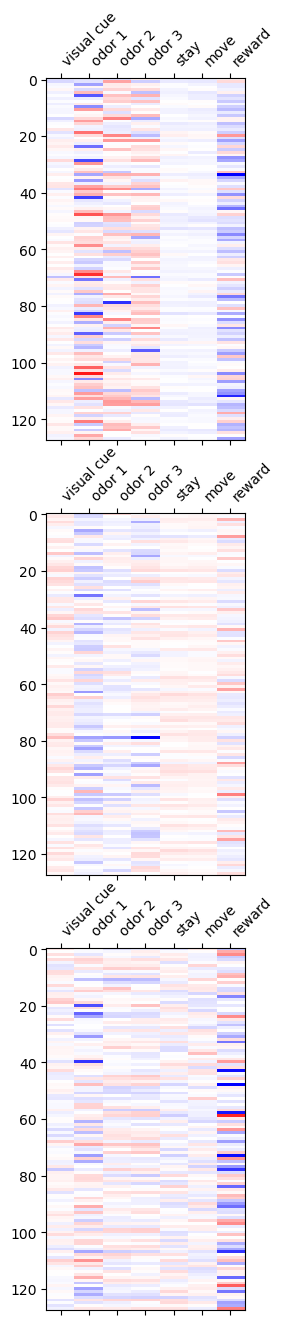

In [5]:
scale = 0.8
fig, axs = plt.subplots(3, 1, figsize=(6 * scale, 20 * scale))

w_ih = network.rnn.weight_ih.data.numpy()
b_ih = network.rnn.bias_ih.data.numpy()
m = np.abs(w_ih[:HIDDEN_SIZE, :]).max()
axs[0].matshow(w_ih[:HIDDEN_SIZE, :], cmap='bwr', vmin=-m, vmax=m, aspect=0.1)
m = np.abs(w_ih[HIDDEN_SIZE:2*HIDDEN_SIZE, :]).max()
axs[1].matshow(w_ih[HIDDEN_SIZE:2*HIDDEN_SIZE, :], cmap='bwr', vmin=-m, vmax=m, aspect=0.1)
m = np.abs(w_ih[2*HIDDEN_SIZE:3*HIDDEN_SIZE, :]).max()
axs[2].matshow(w_ih[2*HIDDEN_SIZE:3*HIDDEN_SIZE, :], cmap='bwr', vmin=-m, vmax=m, aspect=0.1)

for i in range(3):
    axs[i].set_xticks(np.arange(7))
    axs[i].set_xticklabels([
        'visual cue',
        'odor 1',
        'odor 2',
        'odor 3',
        'stay',
        'move',
        'reward',
    ], rotation=45, ha='left')

In [6]:
def load_numpy(data_path, averaging_size=1):
    file_names = glob.glob(data_path)
    data = []
    for file_name in file_names:
        data_for_file = np.load(file_name)
        data.append(data_for_file)
    data = np.concatenate(data, axis=1)
    if averaging_size == 1:
        return data
    reduced_data = np.empty((data.shape[0], int(data.shape[1] / averaging_size)))
    for k in range(0, int(data.shape[1] / averaging_size) * averaging_size, averaging_size):
        reduced_data[:, int(k / averaging_size)] = data[:, k:k + averaging_size].mean(axis=1)
    return reduced_data

env_idx = 210

data = load_numpy('../../results/rl_agent_outputs/structural_priors_fixed_mapping_02_test_2024-12-30_17_09_15_004440_var_noise_0_activity_weight_0/hidden_state/*.npy')
data = np.transpose(data, [2, 1, 0])

print(data.shape)
flattened_data = data.reshape(data.shape[0], data.shape[1] * data.shape[2], order='C')

pca = PCA()
print(flattened_data.shape)
pc_activities = pca.fit_transform(flattened_data.T)
print('s:', pc_activities.T.shape)
pc_activities = pc_activities.T.reshape(data.shape, order='C')

(128, 240, 20000)
(128, 4800000)
s: (128, 4800000)


(128, 240, 20000)


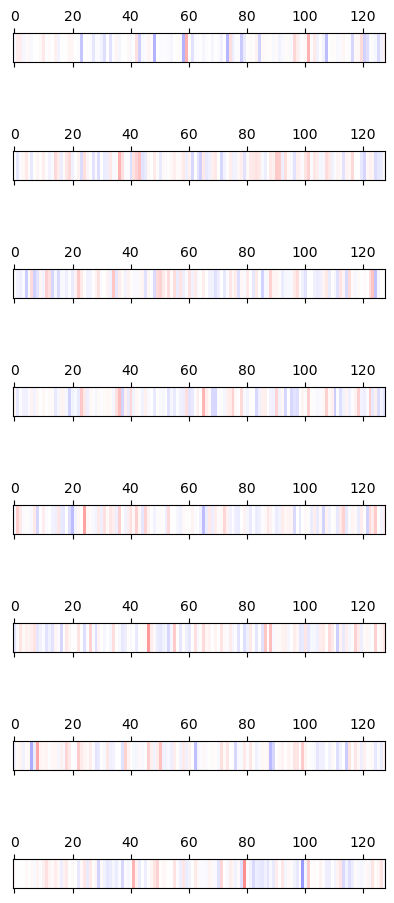

In [7]:
print(pc_activities.shape)
explained_variance_ratios = pca.explained_variance_ratio_
pca.components_

scale = 0.8
fig, axs = plt.subplots(8, 1, figsize=(6 * scale, 15 * scale))

for i in range(8):
    axs[i].matshow(pca.components_[i, :, np.newaxis].T, aspect=10, cmap='bwr', vmin=-1, vmax=1)
    axs[i].set_yticks([])

### How do odors align with principal components of activity?

[-0.1559219  -0.06007405  0.18642804  0.08775762  0.11601576 -0.27439058
 -0.0797376   0.109873  ]



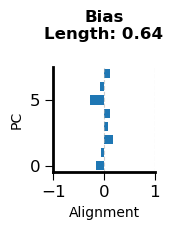

In [8]:
def gen_alignment_chart(w, vs, vlim=None, title='', bias=None):
    if bias is None:
        bias = np.zeros_like(w)
    if vlim is None:
        vlim = vs.shape[0]
    vs = vs[:vlim, :]
    w_norm = np.linalg.norm(w)
    scale = 0.6
    
    # Set the figure and axes
    width = 3 * scale
    if (np.sum(bias) == 0):
        fig, axs = plt.subplots(1, 1, figsize=(width, 4 * scale), sharex=True, sharey=True)
        axs = [axs]
    else:
        fig, axs = plt.subplots(1, 2, figsize=(2 * width, 4 * scale), sharex=True, sharey=True)

    # Define indices for the bars
    indices = np.arange(vlim)
    
    # Calculate the alignments
    alignments = np.dot(vs, w / w_norm)
    print(alignments)
    
    # Create the horizontal bar chart
    axs[0].barh(indices, alignments, height=0.7)
    # Set the title with a specific font weight
    axs[0].set_title(f'{title}\nLength: {w_norm:.2f}', fontsize=12, fontweight='bold', pad=20)
    
    if not (np.sum(bias) == 0):
        axs[1].barh(indices, np.dot(vs, (w - bias) / np.linalg.norm(w - bias)), height=0.7)
        axs[1].set_title(f'After bias', fontsize=12, fontweight='bold', pad=20)

    # Customize the axes labels and limits
    axs[0].set_xlim(-1, 1)
    axs[0].set_ylim(-0.5, vlim - 0.5)

    for k in range(len(axs)):
        # Hide the top and right spines for a cleaner look
        axs[k].spines['top'].set_visible(False)
        axs[k].spines['right'].set_visible(False)
    
        # Thicken the axes lines (left, bottom)
        axs[k].spines['left'].set_linewidth(2)
        axs[k].spines['bottom'].set_linewidth(2)
        
        # Add gridlines for better readability
        axs[k].grid(True, axis='x', linestyle='--', alpha=0.6)
    
        # Adjust ticks and labels
        axs[k].tick_params(axis='both', labelsize=12, length=6)
    
    axs[0].set_xlabel('Alignment')
    axs[0].set_ylabel('PC')

    # Show the plot
    plt.tight_layout()

b_ih_hh = b_ih[2*HIDDEN_SIZE:3*HIDDEN_SIZE]
gen_alignment_chart(b_ih_hh, pca.components_, vlim=8, title=f'Bias')
print()

Visual cue
[ 0.1606993   0.40289932 -0.21153516 -0.21822806 -0.1049764  -0.30887383
  0.22549012  0.13609493]

Odor num 1
[ 0.25404984  0.36495817 -0.14042108 -0.43297654 -0.03708303  0.16874163
 -0.1361062   0.01666113]

Odor num 2
[ 0.06201804  0.04293838 -0.5088575   0.06800587  0.02484446  0.5245961
 -0.03741393 -0.24616545]

Odor num 3
[ 0.03862545 -0.07671905 -0.57906985  0.02722241  0.13606077  0.4258078
  0.0618419  -0.16500998]

Reward
[ 0.81399727 -0.29687953  0.16737586 -0.02740555  0.19289209  0.00241351
  0.0321271  -0.0758796 ]



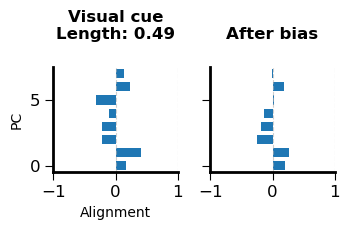

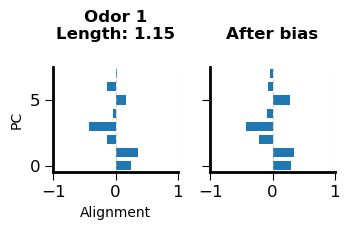

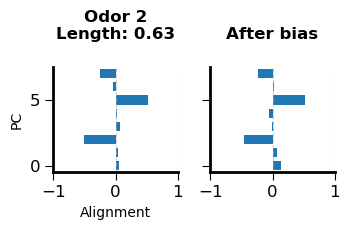

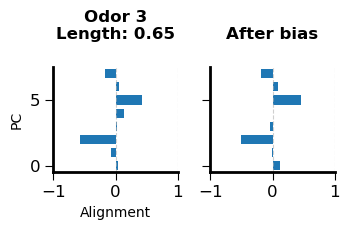

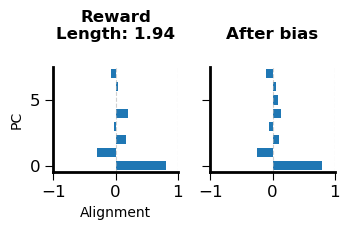

In [9]:
print(f'Visual cue')
w_ih_vc = w_ih[2*HIDDEN_SIZE:3*HIDDEN_SIZE, 0]
gen_alignment_chart(w_ih_vc, pca.components_, vlim=8, title='Visual cue', bias=b_ih_hh)
print()

for odor_num in range(1, 4):
    print(f'Odor num {odor_num}')
    w_ih_odor = w_ih[2*HIDDEN_SIZE:3*HIDDEN_SIZE, odor_num]
    gen_alignment_chart(w_ih_odor, pca.components_, vlim=8, title=f'Odor {odor_num}', bias=b_ih_hh)
    print()

print(f'Reward')
w_ih_reward = w_ih[2*HIDDEN_SIZE:3*HIDDEN_SIZE, -1]
gen_alignment_chart(w_ih_reward, pca.components_, vlim=8, title='Reward', bias=b_ih_hh)
print()
    

(2, 128)
-0.9998481


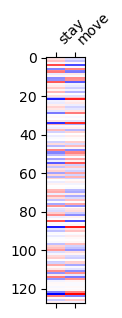

In [10]:
scale = 0.8
fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 4 * scale))

w_action = network.action_arm.weight.data.numpy()
m = np.abs(w_action).max()
axs.matshow(w_action.T, cmap='bwr', vmin=-m, vmax=m, aspect=0.1)
            
axs.set_xticks(np.arange(2))
axs.set_xticklabels([
    'stay',
    'move',
], rotation=45, ha='left')

print(w_action.shape)

print(np.dot(w_action[0, :] / np.linalg.norm(w_action[0, :]), w_action[1, :] / np.linalg.norm(w_action[1, :])))

Stay
[-0.01495164 -0.00790305 -0.9154454   0.08772908 -0.09698826 -0.13566062
  0.0905335  -0.12912416]

Move
[ 0.01452105  0.00594313  0.91599596 -0.08817561  0.09570481  0.13457814
 -0.08988638  0.13100804]



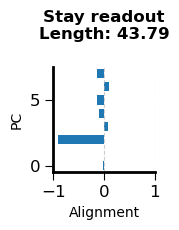

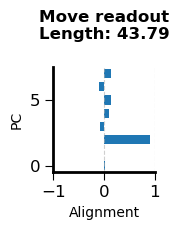

In [48]:
print('Stay')
w_stay_readout = w_action[0, :]
gen_alignment_chart(w_stay_readout, pca.components_, vlim=8, title=f'Stay readout')
print()

print('Move')
w_stay_readout = w_action[1, :]
gen_alignment_chart(w_stay_readout, pca.components_, vlim=8, title=f'Move readout')
print()

Value
[-0.16166148 -0.15759158 -0.17750168  0.12039585  0.00462251 -0.10724251
  0.06744358  0.1631984 ]



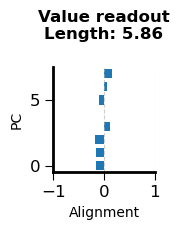

In [52]:
print('Value')
gen_alignment_chart(w_value[0, :], pca.components_, vlim=8, title=f'Value readout')
print()

(1, 128)


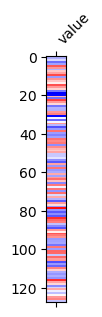

In [51]:
scale = 0.8
fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 4 * scale))

w_value = network.value_arm.weight.data.numpy()
m = np.abs(w_value).max()
axs.matshow(w_value.T, cmap='bwr', vmin=-m, vmax=m, aspect=0.1)
            
axs.set_xticks(np.arange(1))
axs.set_xticklabels([
    'value',
], rotation=45, ha='left')

print(w_value.shape)

### Fixed point finding

In [32]:
fpf_hps = {
		'max_iters': 100000,
		'lr_init': 1e-6,
		'outlier_distance_scale': 10.0,
		'verbose': False, 
		'super_verbose': False,
}
network.rnn.batch_first = True
fpf = FixedPointFinder(network.rnn, **fpf_hps)

# Study the system in the absence of input pulses (e.g., all inputs are 0)
n_initial_states = 200
inputs = np.zeros([n_initial_states, OBS_SIZE + ACTION_SIZE + 1])
samples = np.zeros(flattened_data.shape[1]).astype(bool)
samples[:n_initial_states] = True
np.random.shuffle(samples)
initial_states = flattened_data[:, samples].T
# for i in np.linspace(-1, 1, 10):
#     for j in np.linspace(-0.5, 0.5, 10):
#         initial_states.append(i * pca.components_[0, :] + j * pca.components_[1, :] + 0.1 * pca.components_[2, :])

initial_states = np.array(initial_states)
print(initial_states.shape)

# Run the fixed point finder
unique_fps, all_fps = fpf.find_fixed_points(copy(initial_states), copy(inputs))

# for i in range(100):
#     it = initial_states[i, :]
#     print(np.dot(pca.components_[0, :], it), np.dot(pca.components_[1, :], it))

print(unique_fps)

(200, 128)
	Freezing model parameters so model is not affected by fixed point optimization.
		initial_states: 0 outliers detected (of 200).
		fixed points: 0 outliers detected (of 200).
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.


In [13]:
# plot_fps(unique_fps)

[-0.6260625  -0.10993828  0.2349005   0.28204596  0.36149344 -0.04654245
 -0.0267085   0.0570225 ]

[-0.56895435  0.00847526  0.20014589 -0.20822188 -0.00910181  0.07843878
  0.00163356  0.21581194]

[ 0.2516006   0.18298793 -0.046542   -0.16579126  0.42650878  0.06603222
  0.16933142  0.08879066]

[-0.47042888  0.7316199   0.19982782 -0.04943911  0.00684512  0.04191421
  0.08424217  0.07930289]

[ 0.14526278 -0.5956429   0.2627918   0.08496704  0.01236247  0.0950331
  0.08208652  0.18778998]

[-0.15728343 -0.33718532  0.24975415 -0.18091977  0.11000313  0.14661232
  0.04477361  0.15567257]

[-6.3043481e-01 -2.4156999e-03 -4.3611228e-04  1.5768701e-02
 -5.1363625e-02 -9.1531619e-02  8.1273317e-02  8.7460786e-02]

[ 0.83783305  0.0446054   0.12201639 -0.006153    0.23291948 -0.00402697
  0.03205383  0.0552014 ]

[ 0.6207361   0.26610965 -0.00624803 -0.02673099  0.28736877 -0.05753948
 -0.08353103  0.06238984]

[ 0.41997522 -0.12521653 -0.0092357  -0.15660973  0.28912595 -0.06797954
 -0.

C:\Users\david.bell\AppData\Local\Temp\ipykernel_30416\4035400890.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 1, figsize=(width, 4 * scale), sharex=True, sharey=True)


[-0.6555443   0.00322323 -0.00189017  0.4374113   0.24886218 -0.12999256
 -0.11124983 -0.00864423]

[0.8156098  0.24726063 0.06934216 0.13173135 0.1935936  0.07301675
 0.10274266 0.08040585]

[-0.7113105   0.32617438  0.20951398  0.01284956  0.16705038  0.03186501
 -0.03895276  0.02822012]

[ 0.83858585  0.2720188   0.17955266  0.14862053  0.03651658 -0.00418362
  0.04150521  0.05499423]

[ 0.8188163   0.32141048  0.17709954  0.17905928 -0.05870926  0.05789724
  0.06398915  0.06771871]

[ 0.26737815 -0.54572177  0.26322076  0.12892479  0.08609507  0.08211645
  0.07905702  0.17394729]

[ 0.09538926 -0.14568989  0.24575159 -0.05047751  0.16506645  0.09756718
  0.0317288   0.11142884]

[0.92100644 0.0927545  0.00393546 0.2040886  0.1474337  0.02137947
 0.04452996 0.0392608 ]

[-0.38941717 -0.35255748  0.25962868  0.32941642  0.31203613  0.00694142
  0.02620032  0.06051569]

[-0.1595425  -0.4217683   0.30381048  0.1330214  -0.01940759  0.10024794
  0.11180443  0.14548323]

[ 0.03761099 -0.

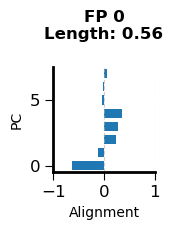

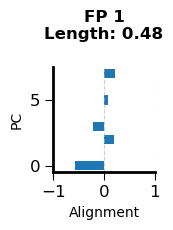

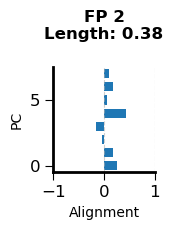

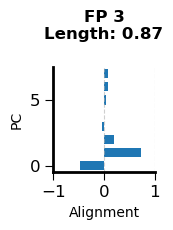

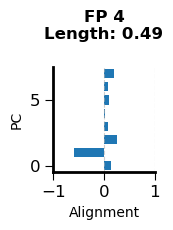

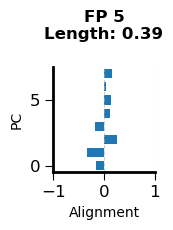

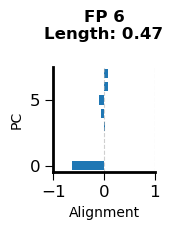

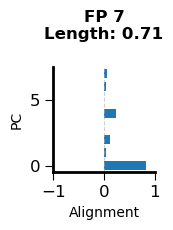

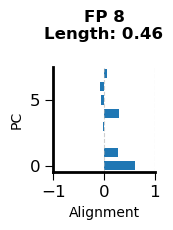

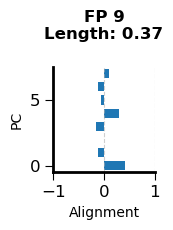

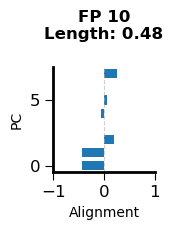

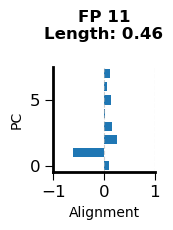

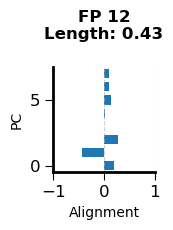

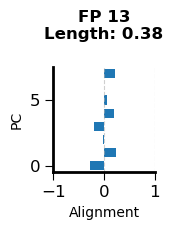

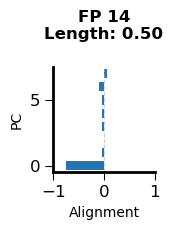

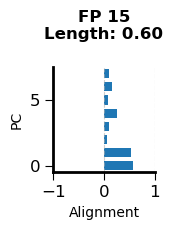

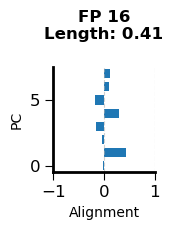

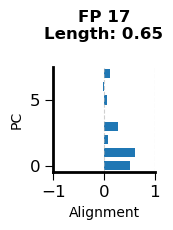

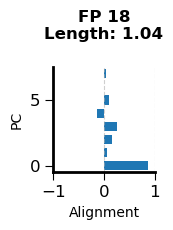

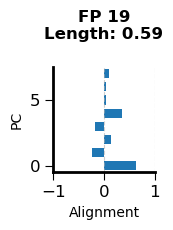

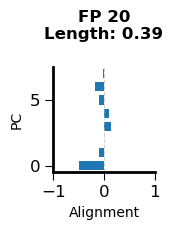

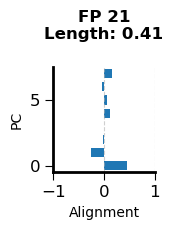

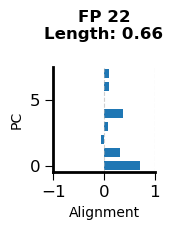

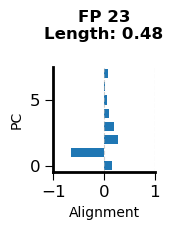

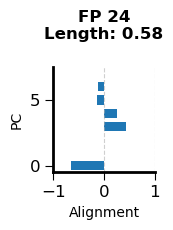

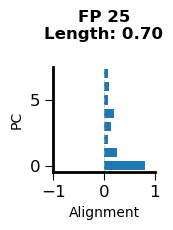

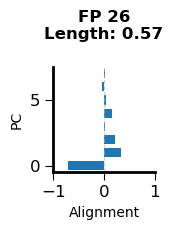

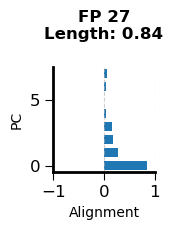

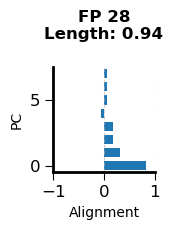

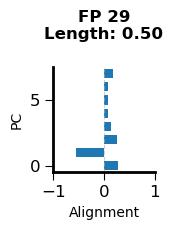

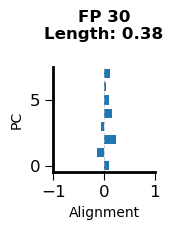

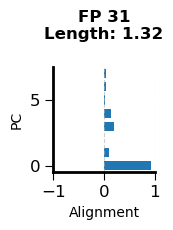

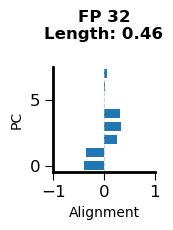

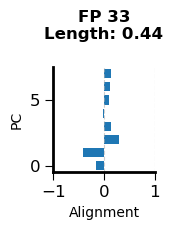

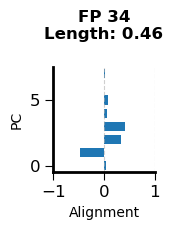

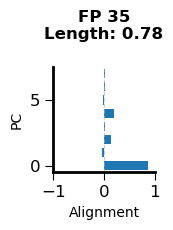

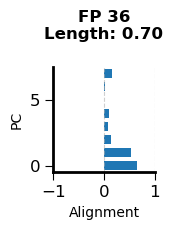

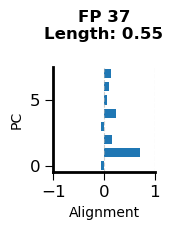

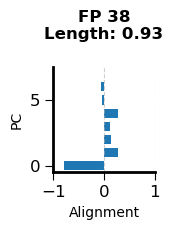

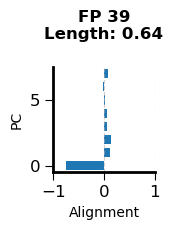

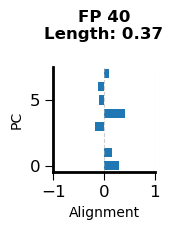

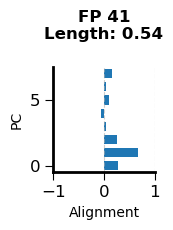

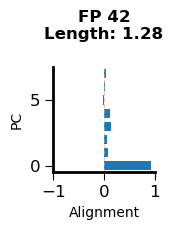

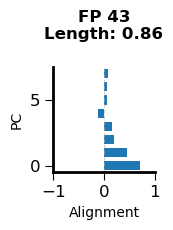

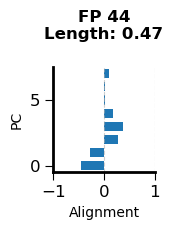

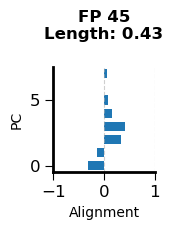

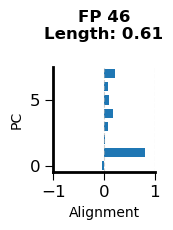

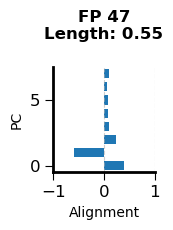

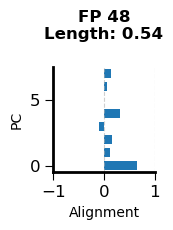

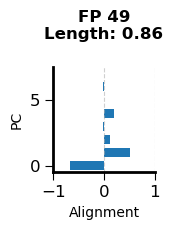

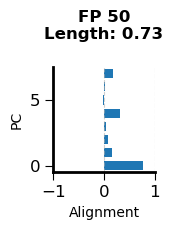

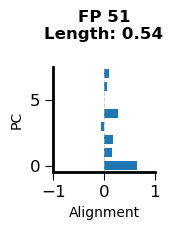

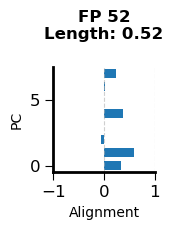

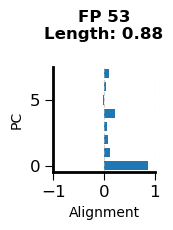

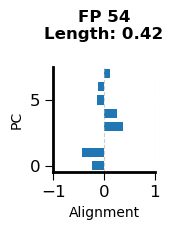

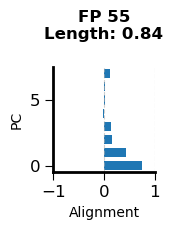

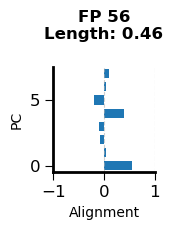

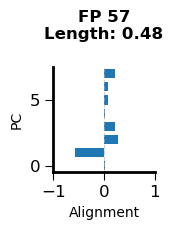

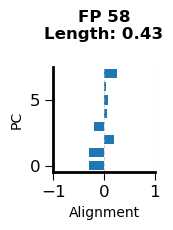

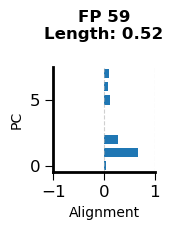

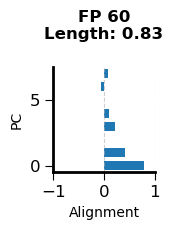

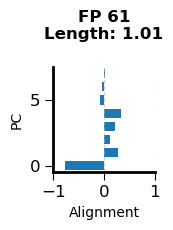

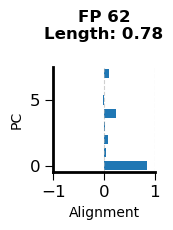

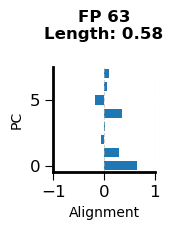

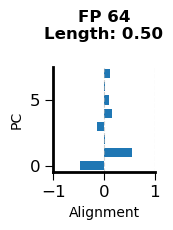

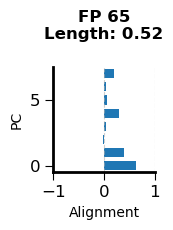

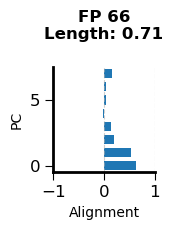

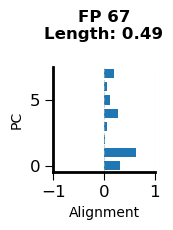

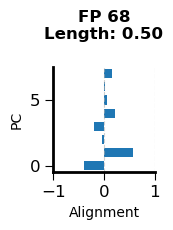

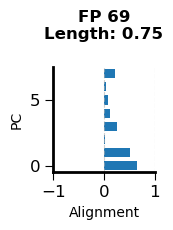

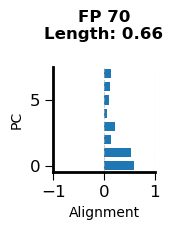

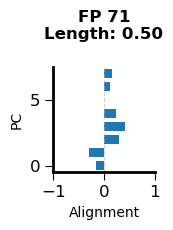

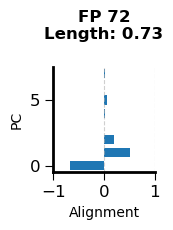

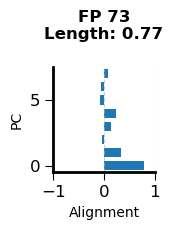

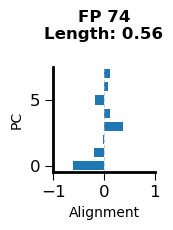

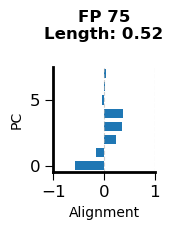

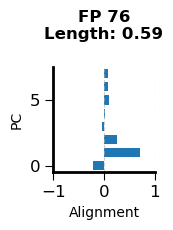

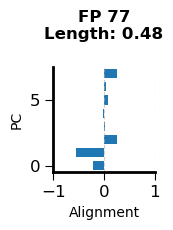

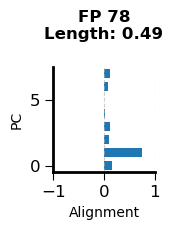

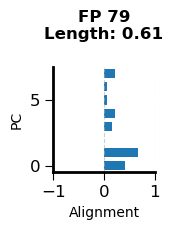

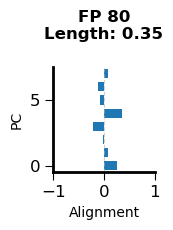

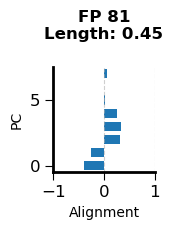

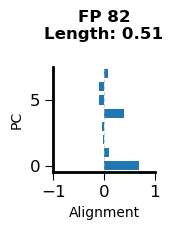

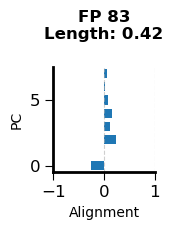

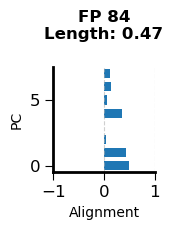

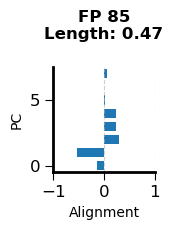

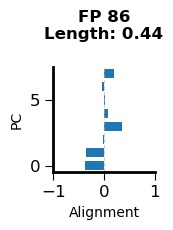

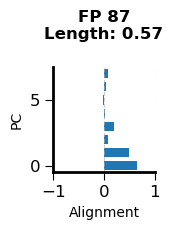

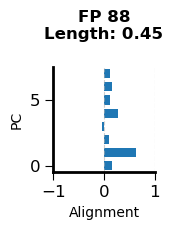

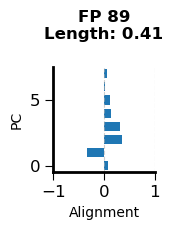

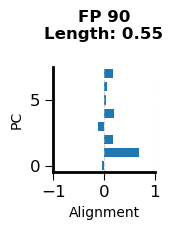

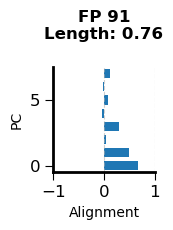

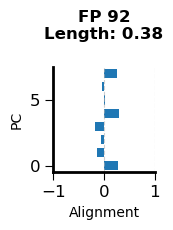

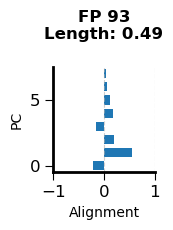

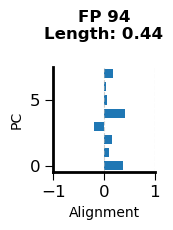

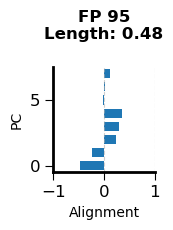

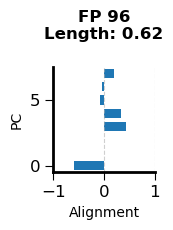

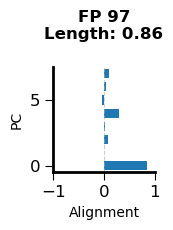

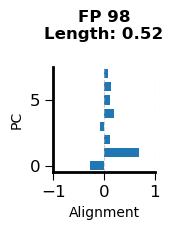

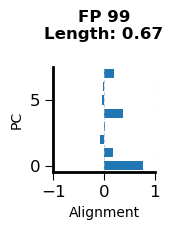

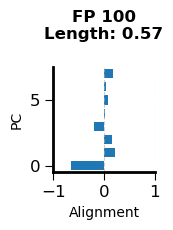

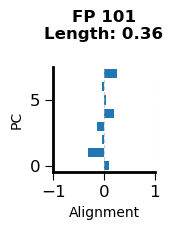

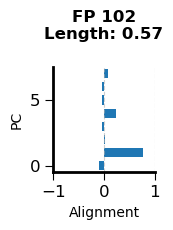

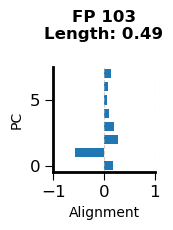

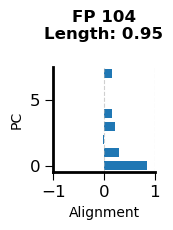

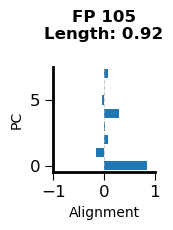

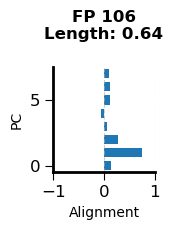

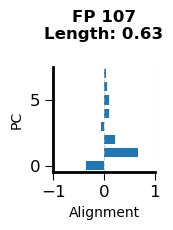

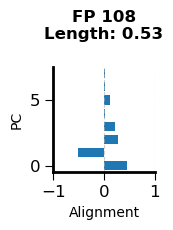

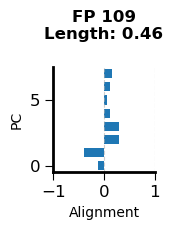

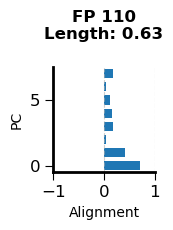

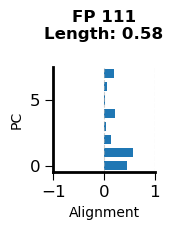

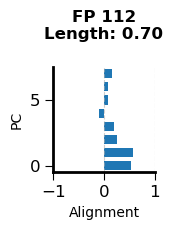

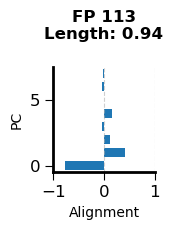

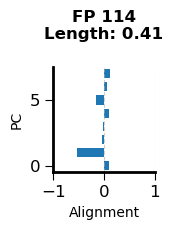

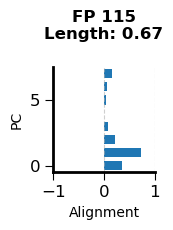

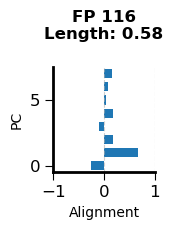

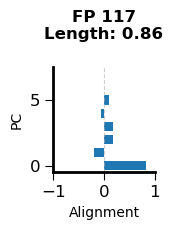

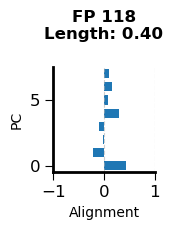

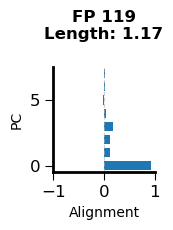

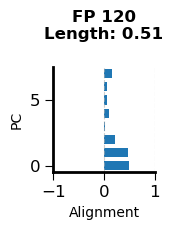

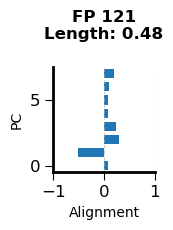

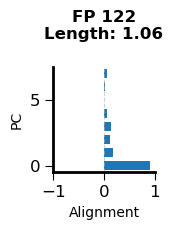

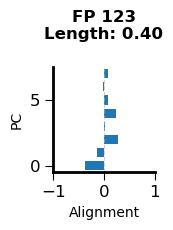

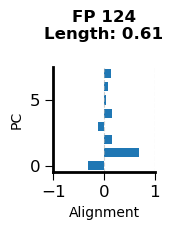

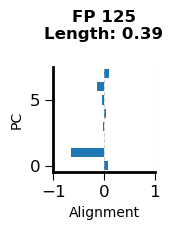

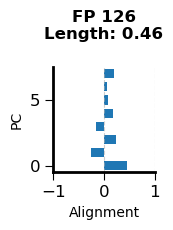

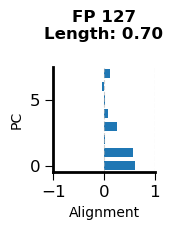

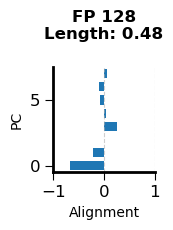

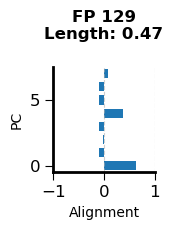

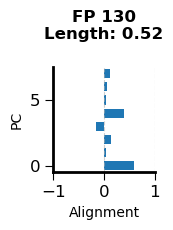

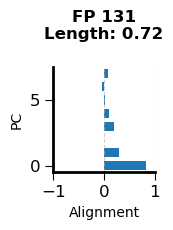

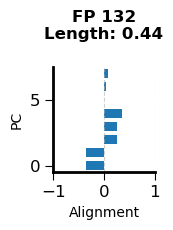

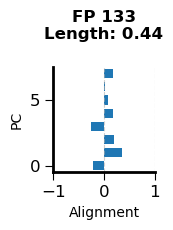

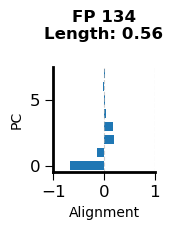

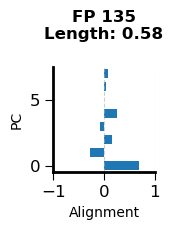

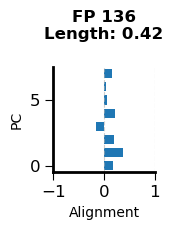

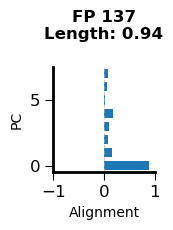

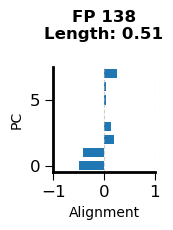

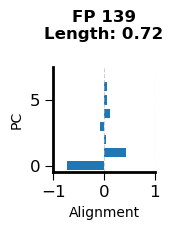

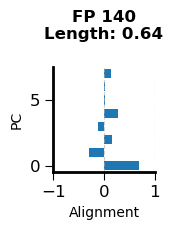

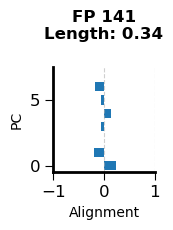

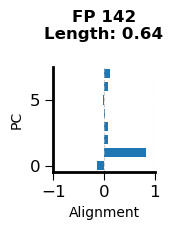

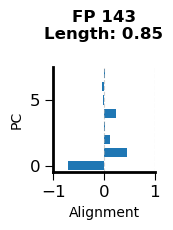

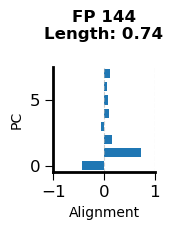

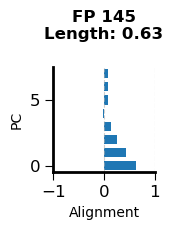

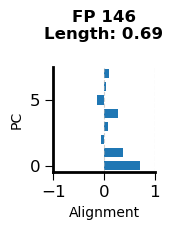

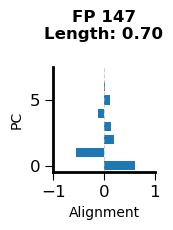

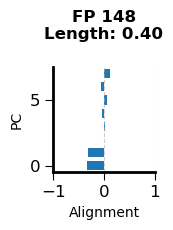

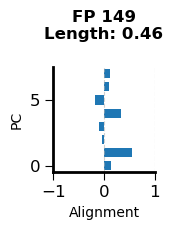

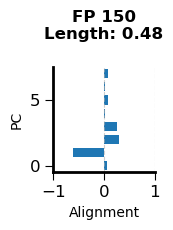

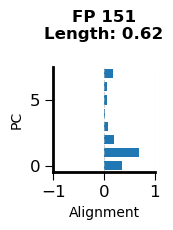

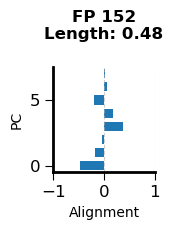

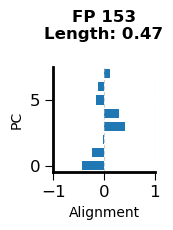

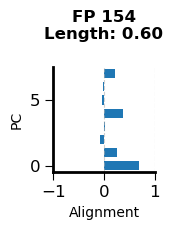

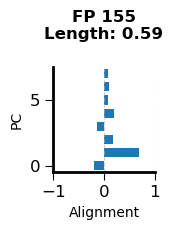

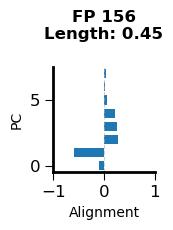

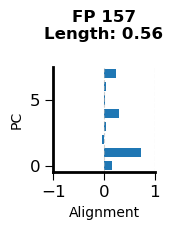

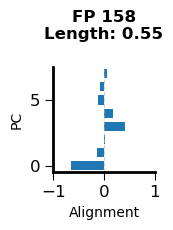

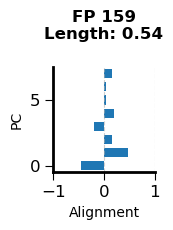

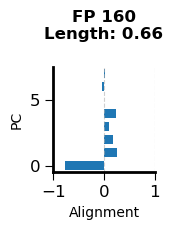

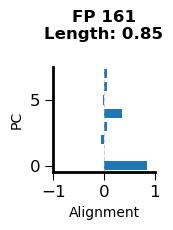

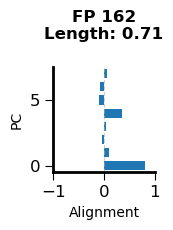

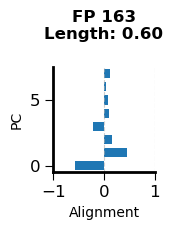

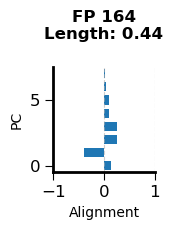

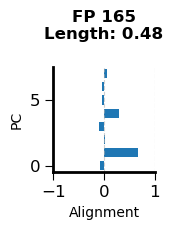

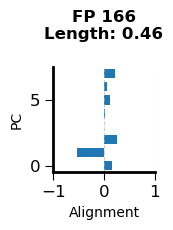

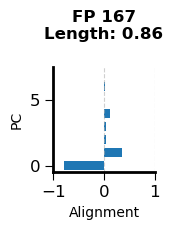

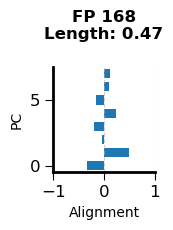

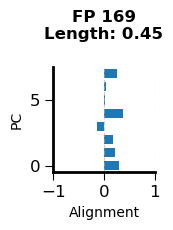

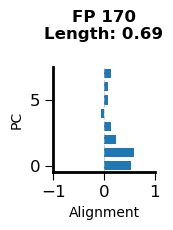

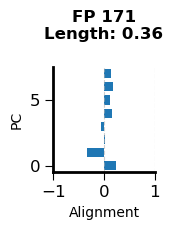

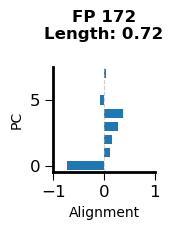

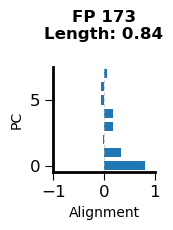

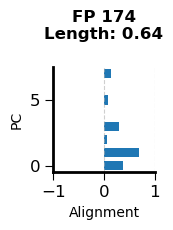

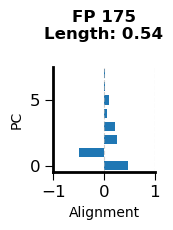

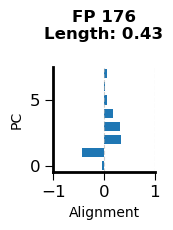

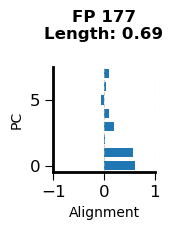

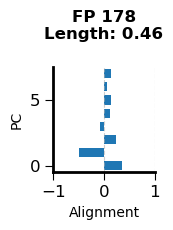

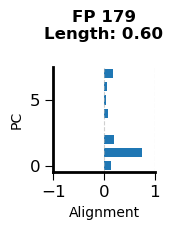

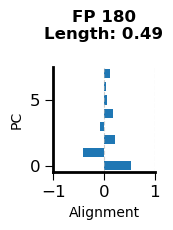

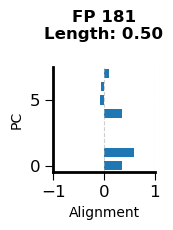

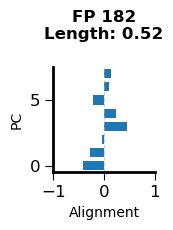

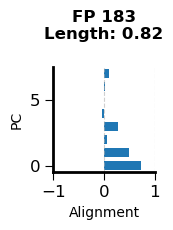

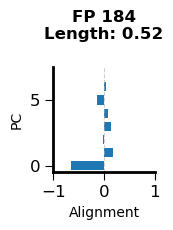

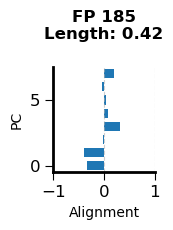

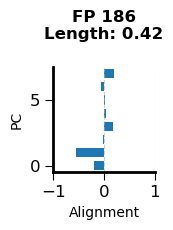

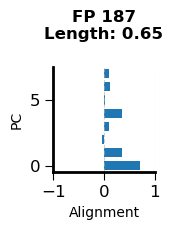

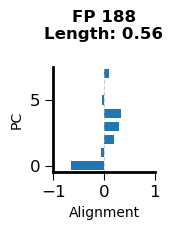

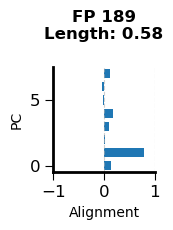

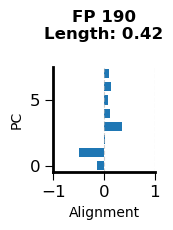

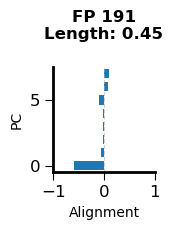

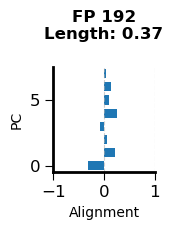

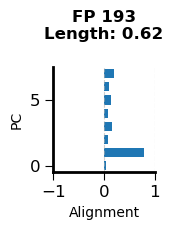

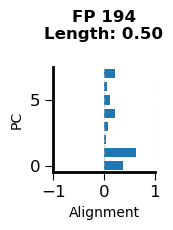

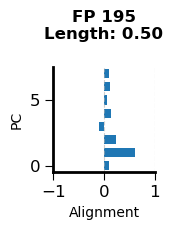

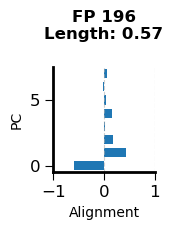

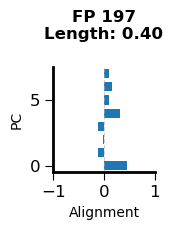

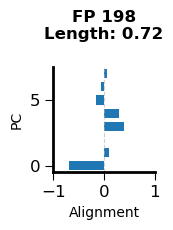

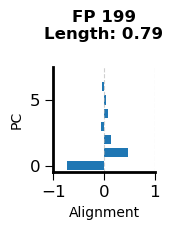

In [14]:
for i_f in range(unique_fps.xstar.shape[0]):
    fp_i = unique_fps.xstar[i_f, :]
    gen_alignment_chart(fp_i, pca.components_, vlim=8, title=f'FP {i_f}')
    print()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


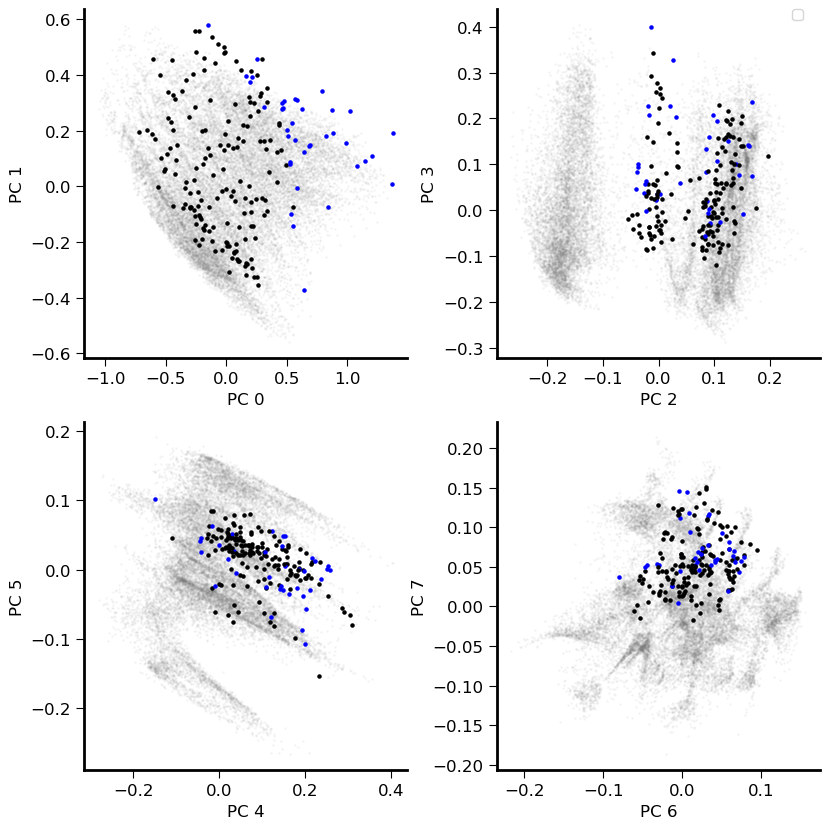

In [35]:
scale = 1.2
fig, axs = plt.subplots(2, 2, figsize=(7 * scale, 7 * scale))

for k in np.arange(0, 8, 2):
    all_mask_off = []
    k_x, k_y = int(k/4), int(k/2) % 2
    
    axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :],
        pc_activities[k+1, env_idx, :],
        s=1,
        zorder=-1,
        c='grey',
        alpha=0.05,
    )

    for i_states in range(initial_states.shape[0]):
        it = initial_states[i_states, :]

        # axs[k_x, k_y].scatter(
        #     [np.dot(it, pca.components_[k, :])],
        #     [np.dot(it, pca.components_[k+1, :])],
        #     color = 'green',
        #     zorder=1
        # )

    for i_f in range(unique_fps.xstar.shape[0]):
        fp = unique_fps[i_f]
        e_vals = fp.eigval_J_xstar[0]
        stable = np.all(np.abs(e_vals) < 1.0)
        axs[k_x, k_y].scatter(
            [np.dot(fp.xstar, pca.components_[k, :])],
            [np.dot(fp.xstar, pca.components_[k+1, :])],
            color = 'black' if stable else 'blue',
            s=5,
        )
    
    axs[k_x, k_y].set_xlabel(f'PC {k}', fontsize=12)
    axs[k_x, k_y].set_ylabel(f'PC {k+1}', fontsize=12)

    # Hide the top and right spines for a cleaner look
    axs[k_x, k_y].spines['top'].set_visible(False)
    axs[k_x, k_y].spines['right'].set_visible(False)

    # Thicken the axes lines (left, bottom)
    axs[k_x, k_y].spines['left'].set_linewidth(2)
    axs[k_x, k_y].spines['bottom'].set_linewidth(2)

    axs[k_x, k_y].tick_params(axis='both', labelsize=12, length=6)
    # axs[int(k/2)].set_aspect('equal')
fig.legend(markerscale=10, bbox_to_anchor=(0.97, 0.99))
fig.tight_layout()

### With stay cue

In [44]:
fpf_hps = {
		'max_iters': 50000,
		'lr_init': 1e-6,
		'outlier_distance_scale': 10.0,
		'verbose': False, 
		'super_verbose': False,
}
network.rnn.batch_first = True
fpf = FixedPointFinder(network.rnn, **fpf_hps)

# Study the system in the absence of input pulses (e.g., all inputs are 0)
n_initial_states = 200
inputs = np.zeros([n_initial_states, OBS_SIZE + ACTION_SIZE + 1])
inputs[:, 4] = 1
samples = np.zeros(flattened_data.shape[1]).astype(bool)
samples[:n_initial_states] = True
np.random.shuffle(samples)
initial_states = flattened_data[:, samples].T
# for i in np.linspace(-1, 1, 10):
#     for j in np.linspace(-0.5, 0.5, 10):
#         initial_states.append(i * pca.components_[0, :] + j * pca.components_[1, :] + 0.1 * pca.components_[2, :])

initial_states = np.array(initial_states)
print(initial_states.shape)

# Run the fixed point finder
unique_fps, all_fps = fpf.find_fixed_points(copy(initial_states), copy(inputs))

# for i in range(100):scale = 1.2
fig, axs = plt.subplots(2, 2, figsize=(7 * scale, 7 * scale))

for k in np.arange(0, 8, 2):
    all_mask_off = []
    k_x, k_y = int(k/4), int(k/2) % 2
    
    axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :],
        pc_activities[k+1, env_idx, :],
        s=1,
        zorder=-1,
        c='grey',
        alpha=0.05,
    )

    for i_states in range(initial_states.shape[0]):
        it = initial_states[i_states, :]

        # axs[k_x, k_y].scatter(
        #     [np.dot(it, pca.components_[k, :])],
        #     [np.dot(it, pca.components_[k+1, :])],
        #     color = 'green',
        #     zorder=1
        # )

    for i_f in range(unique_fps.xstar.shape[0]):
        fp = unique_fps[i_f]
        e_vals = fp.eigval_J_xstar[0]
        stable = np.all(np.abs(e_vals) < 1.0)
        axs[k_x, k_y].scatter(
            [np.dot(fp.xstar, pca.components_[k, :])],
            [np.dot(fp.xstar, pca.components_[k+1, :])],
            color = 'black' if stable else 'blue',
            s=3,
        )
    
    axs[k_x, k_y].set_xlabel(f'PC {k}')
    axs[k_x, k_y].set_ylabel(f'PC {k+1}')

    # Hide the top and right spines for a cleaner look
    axs[k_x, k_y].spines['top'].set_visible(False)
    axs[k_x, k_y].spines['right'].set_visible(False)

    # Thicken the axes lines (left, bottom)
    axs[k_x, k_y].spines['left'].set_linewidth(2)
    axs[k_x, k_y].spines['bottom'].set_linewidth(2)
    # axs[int(k/2)].set_aspect('equal')
fig.legend(markerscale=10, bbox_to_anchor=(0.97, 0.99))
fig.tight_layout()
#     it = initial_states[i, :]
#     print(np.dot(pca.components_[0, :], it), np.dot(pca.components_[1, :], it))

print(unique_fps)

(200, 128)
	Freezing model parameters so model is not affected by fixed point optimization.


KeyboardInterrupt: 

In [ ]:
scale = 1.2
fig, axs = plt.subplots(2, 2, figsize=(7 * scale, 7 * scale))

for k in np.arange(0, 8, 2):
    all_mask_off = []
    k_x, k_y = int(k/4), int(k/2) % 2
    
    axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :],
        pc_activities[k+1, env_idx, :],
        s=1,
        zorder=-1,
        c='grey',
        alpha=0.05,
    )

    for i_states in range(initial_states.shape[0]):
        it = initial_states[i_states, :]

        # axs[k_x, k_y].scatter(
        #     [np.dot(it, pca.components_[k, :])],
        #     [np.dot(it, pca.components_[k+1, :])],
        #     color = 'green',
        #     zorder=1
        # )

    for i_f in range(unique_fps.xstar.shape[0]):
        fp = unique_fps[i_f]
        e_vals = fp.eigval_J_xstar[0]
        stable = np.all(np.abs(e_vals) < 1.0)
        axs[k_x, k_y].scatter(
            [np.dot(fp.xstar, pca.components_[k, :])],
            [np.dot(fp.xstar, pca.components_[k+1, :])],
            color = 'black' if stable else 'blue'
        )
    
    axs[k_x, k_y].set_xlabel(f'PC {k}')
    axs[k_x, k_y].set_ylabel(f'PC {k+1}')
    # axs[int(k/2)].set_aspect('equal')
fig.legend(markerscale=10, bbox_to_anchor=(0.97, 0.99))
fig.tight_layout()

### With visual cue

In [46]:
fpf_hps = {
		'max_iters': 50000,
		'lr_init': 1e-6,
		'outlier_distance_scale': 10.0,
		'verbose': False, 
		'super_verbose': False,
}
network.rnn.batch_first = True
fpf = FixedPointFinder(network.rnn, **fpf_hps)

# Study the system in the absence of input pulses (e.g., all inputs are 0)
n_initial_states = 200
inputs = np.zeros([n_initial_states, OBS_SIZE + ACTION_SIZE + 1])
inputs[:, 0] = 1
samples = np.zeros(flattened_data.shape[1]).astype(bool)
samples[:n_initial_states] = True
np.random.shuffle(samples)
initial_states = flattened_data[:, samples].T
# for i in np.linspace(-1, 1, 10):
#     for j in np.linspace(-0.5, 0.5, 10):
#         initial_states.append(i * pca.components_[0, :] + j * pca.components_[1, :] + 0.1 * pca.components_[2, :])

initial_states = np.array(initial_states)
print(initial_states.shape)

# Run the fixed point finder
unique_fps, all_fps = fpf.find_fixed_points(copy(initial_states), copy(inputs))

# for i in range(100):
#     it = initial_states[i, :]
#     print(np.dot(pca.components_[0, :], it), np.dot(pca.components_[1, :], it))

print(unique_fps)

(200, 128)
	Freezing model parameters so model is not affected by fixed point optimization.
		initial_states: 0 outliers detected (of 200).
		fixed points: 0 outliers detected (of 200).
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


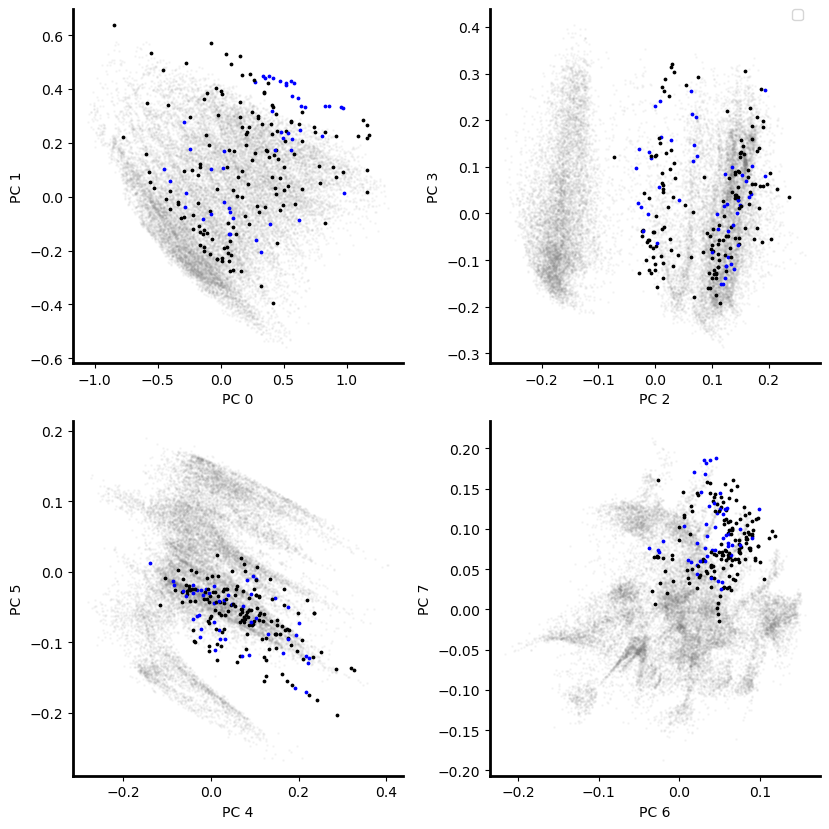

In [47]:
scale = 1.2
fig, axs = plt.subplots(2, 2, figsize=(7 * scale, 7 * scale))

for k in np.arange(0, 8, 2):
    all_mask_off = []
    k_x, k_y = int(k/4), int(k/2) % 2
    
    axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :],
        pc_activities[k+1, env_idx, :],
        s=1,
        zorder=-1,
        c='grey',
        alpha=0.05,
    )

    for i_states in range(initial_states.shape[0]):
        it = initial_states[i_states, :]

        # axs[k_x, k_y].scatter(
        #     [np.dot(it, pca.components_[k, :])],
        #     [np.dot(it, pca.components_[k+1, :])],
        #     color = 'green',
        #     zorder=1
        # )

    for i_f in range(unique_fps.xstar.shape[0]):
        fp = unique_fps[i_f]
        e_vals = fp.eigval_J_xstar[0]
        stable = np.all(np.abs(e_vals) < 1.0)
        axs[k_x, k_y].scatter(
            [np.dot(fp.xstar, pca.components_[k, :])],
            [np.dot(fp.xstar, pca.components_[k+1, :])],
            color = 'black' if stable else 'blue',
            s=3,
        )
    
    axs[k_x, k_y].set_xlabel(f'PC {k}')
    axs[k_x, k_y].set_ylabel(f'PC {k+1}')

    # Hide the top and right spines for a cleaner look
    axs[k_x, k_y].spines['top'].set_visible(False)
    axs[k_x, k_y].spines['right'].set_visible(False)

    # Thicken the axes lines (left, bottom)
    axs[k_x, k_y].spines['left'].set_linewidth(2)
    axs[k_x, k_y].spines['bottom'].set_linewidth(2)
    # axs[int(k/2)].set_aspect('equal')
fig.legend(markerscale=10, bbox_to_anchor=(0.97, 0.99))
fig.tight_layout()

In [ ]:
fpf_hps = {
		'max_iters': 50000,
		'lr_init': 1e-6,
		'outlier_distance_scale': 10.0,
		'verbose': False, 
		'super_verbose': False,
}
network.rnn.batch_first = True
fpf = FixedPointFinder(network.rnn, **fpf_hps)

# Study the system in the absence of input pulses (e.g., all inputs are 0)
n_initial_states = 200
inputs = np.zeros([n_initial_states, OBS_SIZE + ACTION_SIZE + 1])
inputs[:, 0] = 1
inputs[:, 4] = 1
samples = np.zeros(flattened_data.shape[1]).astype(bool)
samples[:n_initial_states] = True
np.random.shuffle(samples)
initial_states = flattened_data[:, samples].T
# for i in np.linspace(-1, 1, 10):
#     for j in np.linspace(-0.5, 0.5, 10):
#         initial_states.append(i * pca.components_[0, :] + j * pca.components_[1, :] + 0.1 * pca.components_[2, :])

initial_states = np.array(initial_states)
print(initial_states.shape)

# Run the fixed point finder
unique_fps, all_fps = fpf.find_fixed_points(copy(initial_states), copy(inputs))

# for i in range(100):
#     it = initial_states[i, :]
#     print(np.dot(pca.components_[0, :], it), np.dot(pca.components_[1, :], it))

print(unique_fps)

In [ ]:
scale = 1.2
fig, axs = plt.subplots(2, 2, figsize=(7 * scale, 7 * scale))

for k in np.arange(0, 8, 2):
    all_mask_off = []
    k_x, k_y = int(k/4), int(k/2) % 2
    
    axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :],
        pc_activities[k+1, env_idx, :],
        s=1,
        zorder=-1,
        c='grey',
        alpha=0.05,
    )

    for i_states in range(initial_states.shape[0]):
        it = initial_states[i_states, :]

        # axs[k_x, k_y].scatter(
        #     [np.dot(it, pca.components_[k, :])],
        #     [np.dot(it, pca.components_[k+1, :])],
        #     color = 'green',
        #     zorder=1
        # )

    for i_f in range(unique_fps.xstar.shape[0]):
        fp = unique_fps[i_f]
        e_vals = fp.eigval_J_xstar[0]
        stable = np.all(np.abs(e_vals) < 1.0)
        axs[k_x, k_y].scatter(
            [np.dot(fp.xstar, pca.components_[k, :])],
            [np.dot(fp.xstar, pca.components_[k+1, :])],
            color = 'black' if stable else 'blue',
            s=3,
        )
    
    axs[k_x, k_y].set_xlabel(f'PC {k}')
    axs[k_x, k_y].set_ylabel(f'PC {k+1}')

    # Hide the top and right spines for a cleaner look
    axs[k_x, k_y].spines['top'].set_visible(False)
    axs[k_x, k_y].spines['right'].set_visible(False)

    # Thicken the axes lines (left, bottom)
    axs[k_x, k_y].spines['left'].set_linewidth(2)
    axs[k_x, k_y].spines['bottom'].set_linewidth(2)
    # axs[int(k/2)].set_aspect('equal')
fig.legend(markerscale=10, bbox_to_anchor=(0.97, 0.99))
fig.tight_layout()

In [40]:
fpf_hps = {
		'max_iters': 50000,
		'lr_init': 1e-6,
		'outlier_distance_scale': 10.0,
		'verbose': False, 
		'super_verbose': False,
}
network.rnn.batch_first = True
fpf = FixedPointFinder(network.rnn, **fpf_hps)

# Study the system in the absence of input pulses (e.g., all inputs are 0)
n_initial_states = 200
inputs = np.zeros([n_initial_states, OBS_SIZE + ACTION_SIZE + 1])
inputs[:, 0] = 1
inputs[:, 5] = 1
samples = np.zeros(flattened_data.shape[1]).astype(bool)
samples[:n_initial_states] = True
np.random.shuffle(samples)
initial_states = flattened_data[:, samples].T
# for i in np.linspace(-1, 1, 10):
#     for j in np.linspace(-0.5, 0.5, 10):
#         initial_states.append(i * pca.components_[0, :] + j * pca.components_[1, :] + 0.1 * pca.components_[2, :])

initial_states = np.array(initial_states)
print(initial_states.shape)

# Run the fixed point finder
unique_fps, all_fps = fpf.find_fixed_points(copy(initial_states), copy(inputs))

# for i in range(100):
#     it = initial_states[i, :]
#     print(np.dot(pca.components_[0, :], it), np.dot(pca.components_[1, :], it))

print(unique_fps)

(200, 128)
	Freezing model parameters so model is not affected by fixed point optimization.
		initial_states: 0 outliers detected (of 200).
		fixed points: 0 outliers detected (of 200).
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


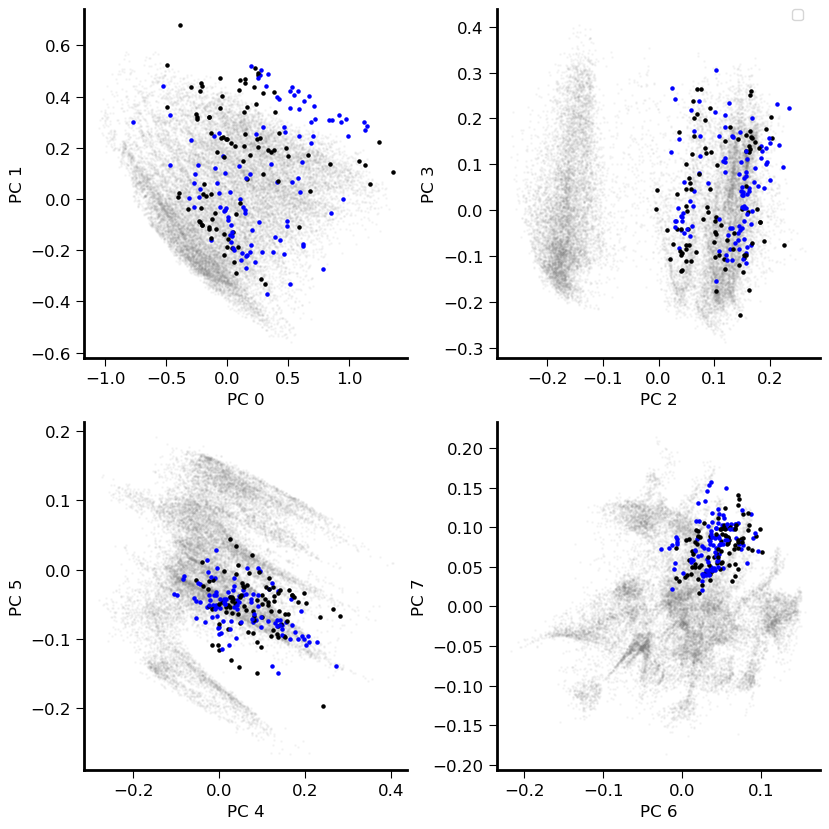

In [41]:
scale = 1.2
fig, axs = plt.subplots(2, 2, figsize=(7 * scale, 7 * scale))

for k in np.arange(0, 8, 2):
    all_mask_off = []
    k_x, k_y = int(k/4), int(k/2) % 2
    
    axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :],
        pc_activities[k+1, env_idx, :],
        s=1,
        zorder=-1,
        c='grey',
        alpha=0.05,
    )

    for i_states in range(initial_states.shape[0]):
        it = initial_states[i_states, :]

        # axs[k_x, k_y].scatter(
        #     [np.dot(it, pca.components_[k, :])],
        #     [np.dot(it, pca.components_[k+1, :])],
        #     color = 'green',
        #     zorder=1
        # )

    for i_f in range(unique_fps.xstar.shape[0]):
        fp = unique_fps[i_f]
        e_vals = fp.eigval_J_xstar[0]
        stable = np.all(np.abs(e_vals) < 1.0)
        axs[k_x, k_y].scatter(
            [np.dot(fp.xstar, pca.components_[k, :])],
            [np.dot(fp.xstar, pca.components_[k+1, :])],
            color = 'black' if stable else 'blue',
            s=5,
        )
    
    axs[k_x, k_y].set_xlabel(f'PC {k}', fontsize=12)
    axs[k_x, k_y].set_ylabel(f'PC {k+1}', fontsize=12)

    # Hide the top and right spines for a cleaner look
    axs[k_x, k_y].spines['top'].set_visible(False)
    axs[k_x, k_y].spines['right'].set_visible(False)

    # Thicken the axes lines (left, bottom)
    axs[k_x, k_y].spines['left'].set_linewidth(2)
    axs[k_x, k_y].spines['bottom'].set_linewidth(2)

    axs[k_x, k_y].tick_params(axis='both', labelsize=12, length=6)
    # axs[int(k/2)].set_aspect('equal')
fig.legend(markerscale=10, bbox_to_anchor=(0.97, 0.99))
fig.tight_layout()

In [42]:
fpf_hps = {
		'max_iters': 50000,
		'lr_init': 1e-6,
		'outlier_distance_scale': 10.0,
		'verbose': False, 
		'super_verbose': False,
}
network.rnn.batch_first = True
fpf = FixedPointFinder(network.rnn, **fpf_hps)

# Study the system in the absence of input pulses (e.g., all inputs are 0)
n_initial_states = 200
inputs = np.zeros([n_initial_states, OBS_SIZE + ACTION_SIZE + 1])
inputs[:, 5] = 1
samples = np.zeros(flattened_data.shape[1]).astype(bool)
samples[:n_initial_states] = True
np.random.shuffle(samples)
initial_states = flattened_data[:, samples].T
# for i in np.linspace(-1, 1, 10):
#     for j in np.linspace(-0.5, 0.5, 10):
#         initial_states.append(i * pca.components_[0, :] + j * pca.components_[1, :] + 0.1 * pca.components_[2, :])

initial_states = np.array(initial_states)
print(initial_states.shape)

# Run the fixed point finder
unique_fps, all_fps = fpf.find_fixed_points(copy(initial_states), copy(inputs))

# for i in range(100):
#     it = initial_states[i, :]
#     print(np.dot(pca.components_[0, :], it), np.dot(pca.components_[1, :], it))

print(unique_fps)

(200, 128)
	Freezing model parameters so model is not affected by fixed point optimization.
		initial_states: 0 outliers detected (of 200).
		fixed points: 0 outliers detected (of 200).
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


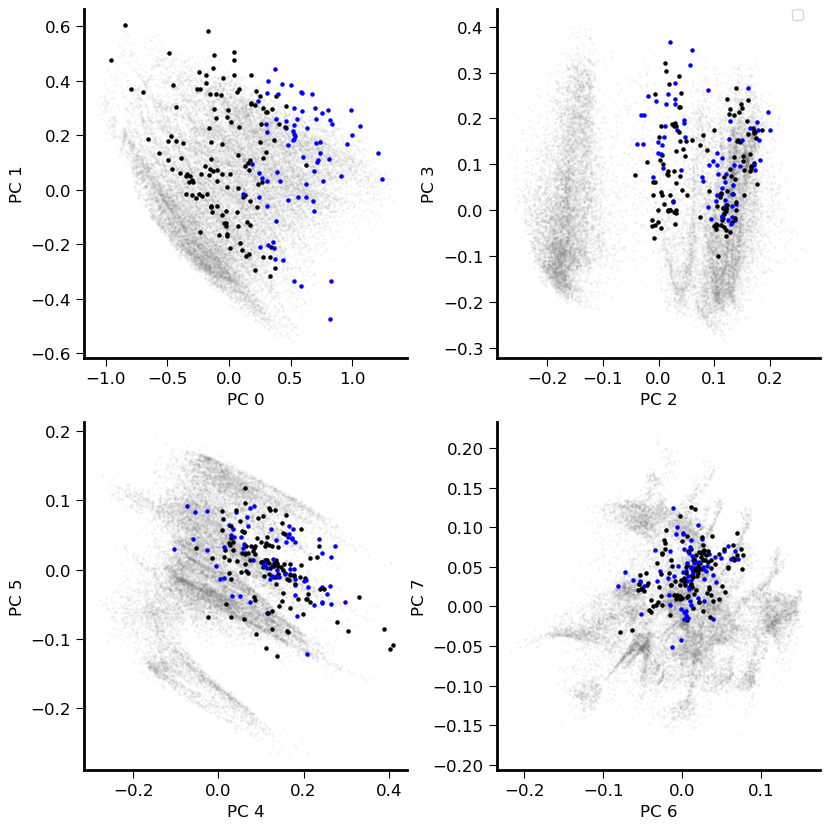

In [43]:
scale = 1.2
fig, axs = plt.subplots(2, 2, figsize=(7 * scale, 7 * scale))

for k in np.arange(0, 8, 2):
    all_mask_off = []
    k_x, k_y = int(k/4), int(k/2) % 2
    
    axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :],
        pc_activities[k+1, env_idx, :],
        s=1,
        zorder=-1,
        c='grey',
        alpha=0.05,
    )

    for i_states in range(initial_states.shape[0]):
        it = initial_states[i_states, :]

        # axs[k_x, k_y].scatter(
        #     [np.dot(it, pca.components_[k, :])],
        #     [np.dot(it, pca.components_[k+1, :])],
        #     color = 'green',
        #     zorder=1
        # )

    for i_f in range(unique_fps.xstar.shape[0]):
        fp = unique_fps[i_f]
        e_vals = fp.eigval_J_xstar[0]
        stable = np.all(np.abs(e_vals) < 1.0)
        axs[k_x, k_y].scatter(
            [np.dot(fp.xstar, pca.components_[k, :])],
            [np.dot(fp.xstar, pca.components_[k+1, :])],
            color = 'black' if stable else 'blue',
            s=5,
        )
    
    axs[k_x, k_y].set_xlabel(f'PC {k}', fontsize=12)
    axs[k_x, k_y].set_ylabel(f'PC {k+1}', fontsize=12)

    # Hide the top and right spines for a cleaner look
    axs[k_x, k_y].spines['top'].set_visible(False)
    axs[k_x, k_y].spines['right'].set_visible(False)

    # Thicken the axes lines (left, bottom)
    axs[k_x, k_y].spines['left'].set_linewidth(2)
    axs[k_x, k_y].spines['bottom'].set_linewidth(2)

    axs[k_x, k_y].tick_params(axis='both', labelsize=12, length=6)
    # axs[int(k/2)].set_aspect('equal')
fig.legend(markerscale=10, bbox_to_anchor=(0.97, 0.99))
fig.tight_layout()